# General Graph Coloring Using Grover's Search (Maximum Four Colors)

This project implements a quantum approach to the graph coloring problem using Grover’s search algorithm, constrained to a maximum of four colors. By encoding only valid color pairings that satisfy graph constraints, the solution leverages amplitude amplification in Qiskit to efficiently search for valid colorings within a reduced state space.

In [9]:
# Subside Warnings

import warnings
warnings.filterwarnings("ignore")

## Problem Definition

This project defines a graph coloring problem by representing the graph with a specified number of vertices and edges. Each problem instance calculates the number of qubits required for encoding both node color assignments (using two qubits per node for up to four colors) and edge constraints, plus one auxiliary qubit. A visualization of the graph structure is also provided to better understand the problem configuration.

Number of Vertices: 3
Number of Edges: 3
Edges List: [(0, 1), (1, 2), (0, 2)]

Number of Qubits: 10


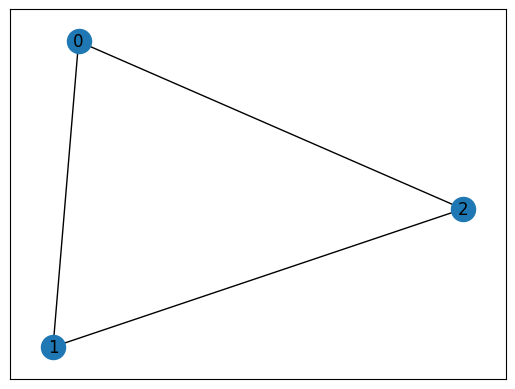

In [10]:
import networkx as nx
from networkx import Graph
from typing import List, Tuple

class Problem:
    def __init__(self, num_vertices: int, edges_list: List[Tuple[int, int]]) -> None:
        self.num_vertices = num_vertices
        self.edges_list = edges_list

        self.num_edges = len(edges_list)
        self.num_qubits = (2 * num_vertices) + self.num_edges + 1

    def __repr__(self) -> str:
        return "\n".join([
            f"Number of Vertices: {self.num_vertices}",
            f"Number of Edges: {self.num_edges}",
            f"Edges List: {self.edges_list}",
            f"\nNumber of Qubits: {self.num_qubits}"
        ])

    def display_graph(self) -> None:
        G = Graph()
        G.add_nodes_from(range(self.num_vertices))
        G.add_edges_from(self.edges_list)
        nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=True)

problem = Problem(num_vertices=3, edges_list=[(0, 1), (1, 2), (0, 2)])
print(problem)
problem.display_graph()

## Utility Class

The Utils class provides a collection of static utility functions for visualizing quantum states, testing circuit behavior, detecting entanglement, simulating quantum circuits, and calculating the number of Grover iterations. These tools are designed to support experimentation and debugging in Qiskit-based quantum computing projects.

### Method Descriptions

 - `test_label_circuit(label: str, instruction: QuantumCircuit | Operator) -> Statevector`: Initializes a quantum state from a computational basis label (e.g., '000'), applies a given quantum circuit or operator, and displays the initial and resulting statevectors in LaTeX format. Returns the output statevector.

 - `is_entangled(state: Statevector, epsilon: float = 1e-10) -> bool`: Determines whether the input quantum state is entangled by computing the entropy of reduced density matrices for each individual qubit. If any qubit has non-zero entropy beyond a small threshold, the state is considered entangled.

 - `simulate(circuit: QuantumCircuit, num_shots: int = 1024, display_circuit: bool = False) -> None`: Simulates the execution of a quantum circuit using Qiskit’s AerSimulator. Measures the first 2 * num_vertices qubits, optionally displays the circuit diagram, and shows the resulting measurement histogram. (Note: depends on a global problem object to determine the number of qubits to measure.)

 - `get_num_iter(num_qubits: int | None = None, num_states: int | None = None, num_solutions: int = None) -> int`: Calculates the optimal number of Grover iterations given the number of total states and valid solutions. Defaults to 1 solution and computes the total search space from the number of qubits if num_states is not provided.

In [11]:
from qiskit.quantum_info import Statevector, Operator, DensityMatrix, partial_trace, entropy
from IPython.display import display
from qiskit import QuantumCircuit, transpile
from qiskit_aer.backends import AerSimulator
from qiskit.visualization import plot_histogram
from typing import Optional, Union
import numpy as np

class Utils:

    @staticmethod
    def test_label_circuit(label: str, instruction: Union[QuantumCircuit, Operator]) -> Statevector:
        """Display input and output statevectors for a given label and instruction."""
        test_vector_input = Statevector.from_label(label)
        display(test_vector_input.draw("latex", prefix="\psi_{input} = "))

        test_vector_output = test_vector_input.evolve(instruction)
        display(test_vector_output.draw("latex", prefix="\psi_{output} = O \psi_{input} = "))

        return test_vector_output

    @staticmethod
    def is_entangled(state: Statevector, epsilon: float = 1e-10) -> bool:
        """Check whether a quantum state is entangled based on von Neumann entropy."""
        num_qubits = state.num_qubits
        density_matrix = DensityMatrix(state)

        for qubit in range(num_qubits):
            trace_out = [i for i in range(num_qubits) if i != qubit]
            reduced_dm = partial_trace(density_matrix, trace_out)

            if entropy(reduced_dm) > epsilon:
                return True
        return False

    @staticmethod
    def simulate(circuit: QuantumCircuit, qubit_count: int, num_shots: int = 1024, display_circuit: bool = False) -> None:
        """Simulate a quantum circuit and display histogram of results."""
        circuit.measure(range(qubit_count), range(qubit_count))

        backend = AerSimulator()
        transpiled = transpile(circuit, backend=backend)

        if display_circuit:
            display(transpiled.draw("mpl"))

        result = backend.run(transpiled, shots=num_shots).result()
        counts = result.get_counts()
        display(plot_histogram(counts, figsize=(15, 8)))

    @staticmethod
    def get_num_iter(num_qubits: Optional[int] = None, num_states: Optional[int] = None, num_solutions: int = 1) -> int:
        """Calculate optimal number of Grover iterations."""
        if num_solutions <= 0:
            raise ValueError("Number of solutions must be positive.")

        if num_states is None:
            if num_qubits is None:
                raise ValueError("Either num_states or num_qubits must be provided.")
            num_states = 2 ** num_qubits

        return int(np.floor((np.pi / 4) * np.sqrt(num_states / num_solutions)))

## Grover's Search Class

The GroversSearch class encapsulates the core components required to implement Grover's search algorithm for constraint-based problems like graph coloring. It provides quantum operators for building oracles, initializing custom superposition states, and applying Grover's diffusion step.

### Method Descriptions

 - `ORGate() -> Operator`: Constructs a 3-qubit quantum OR gate using a Toffoli (CCX) gate and returns it as a unitary operator.

 - `similarity_operator() -> Operator`: Creates a 5-qubit circuit that compares the color encodings of two graph vertices and outputs a signal indicating a color match using the custom OR gate.

 - `grover_oracle(num_qubits, num_vertices, edges_list) -> Operator`: Builds a Grover oracle circuit that marks invalid graph colorings—specifically, cases where adjacent vertices share the same color—using ancilla qubits to track violations based on the edge list.

 - `circuit_initializer(num_qubits, restrict_states) -> QuantumCircuit`: Initializes the quantum state as a uniform superposition over only the allowed computational basis states, excluding those containing restricted color patterns.

 - `diffusion_operator(num_vertices, custom_initializer=None) -> Operator`: Constructs the Grover diffusion operator based on either a uniform or custom-initialized quantum state, reflecting about the average amplitude to amplify valid solutions.

In [24]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator, Statevector
from itertools import product
from typing import List, Tuple, Optional
import numpy as np
import textwrap

class GroversSearch:

    @staticmethod
    def ORGate() -> Operator:
        """Constructs a 3-qubit OR gate using Toffoli logic."""
        circuit = QuantumCircuit(3)
        circuit.x(0)
        circuit.x(1)
        circuit.ccx(0, 1, 2)
        circuit.x([0, 1, 2])
        return Operator(circuit)

    @staticmethod
    def similarity_operator() -> Operator:
        """Creates a 5-qubit operator to compare two 2-qubit vertex encodings."""
        circuit = QuantumCircuit(5)
        circuit.cx(0, 2)
        circuit.cx(1, 3)
        circuit.append(GroversSearch.ORGate(), [2, 3, 4])
        circuit.cx(0, 2)
        circuit.cx(1, 3)
        return Operator(circuit)

    @staticmethod
    def grover_oracle(num_qubits: int, num_vertices: int, edges_list: List[Tuple[int, int]]) -> Operator:
        """Constructs a Grover oracle that marks invalid colorings where adjacent vertices share the same color."""
        ancilla_qubits = list(range(num_vertices * 2, num_qubits - 1))
        vertex_qubits = [[2 * i, 2 * i + 1] for i in range(num_vertices)]
        sim_op = GroversSearch.similarity_operator()
        circuit = QuantumCircuit(num_qubits)

        # Apply similarity operator to each edge
        for i, (u, v) in enumerate(edges_list):
            circuit.append(sim_op, vertex_qubits[u] + vertex_qubits[v] + [ancilla_qubits[i]])

        # Phase flip if all ancilla qubits are 1
        output_qubit = num_qubits - 1
        circuit.h(output_qubit)
        circuit.mcx(ancilla_qubits, output_qubit)
        circuit.h(output_qubit)

        # Uncompute to restore ancilla qubits
        for i, (u, v) in enumerate(edges_list):
            circuit.append(sim_op, vertex_qubits[u] + vertex_qubits[v] + [ancilla_qubits[i]])

        return Operator(circuit)

    @staticmethod
    def circuit_initializer(num_qubits: int, restrict_states: List[str]) -> Operator:
        """Initializes a custom uniform superposition excluding restricted color combinations."""
        # Generate all basis states and split into 2-bit chunks
        bin_seq = ["".join(bits) for bits in product("01", repeat=num_qubits)]
        split_states = [textwrap.wrap(state, 2) for state in bin_seq]

        # Filter allowed states
        allowed_states = ["".join(state) for state in split_states
                          if not any(restrict in state for restrict in restrict_states)]

        amplitude = 1 / np.sqrt(len(allowed_states))
        state_vector = [amplitude if state in allowed_states else 0 for state in bin_seq]
        psi_0 = Statevector(state_vector)

        # Create and return initialization operator
        circuit = QuantumCircuit(num_qubits)
        circuit.initialize(psi_0)

        circuit = transpile(circuit)
        circuit.data = [inst for inst in circuit.data if inst.operation.name != "reset"]

        return Operator(circuit.to_gate())

    @staticmethod
    def diffusion_operator(num_vertices: int, custom_initializer: Optional[Operator] = None) -> Operator:
        """Creates the Grover diffusion operator based on uniform or custom initialization."""
        num_qubits = num_vertices * 2 + 1
        circuit = QuantumCircuit(num_qubits)

        if custom_initializer:
            circuit.append(custom_initializer, range(num_qubits - 1))
        else:
            circuit.h(range(num_qubits - 1))

        circuit.h(num_qubits - 1)

        state = Statevector.from_instruction(circuit)
        outer_product = np.outer(state, state)

        return Operator(2 * outer_product - np.eye(2 ** num_qubits))

## Apply Grover's Search on the Problem (with all State Space, i.e., Super-Position)

This section demonstrates the application of Grover’s search algorithm to the graph coloring problem by exploring the full state space in quantum superposition. Initially, the quantum circuit is constructed by placing the coloring qubits and the output qubit into uniform superposition states using Hadamard gates. The custom Grover oracle operator is then applied to mark invalid colorings where adjacent vertices share the same color. Following the oracle, the Grover diffusion operator is used to amplify the amplitudes of valid color assignments. This specific example executes one iteration of Grover’s algorithm, which is often sufficient to observe the amplification effect in small-scale problems. The quantum circuit is visualized to help understand its structure and flow.

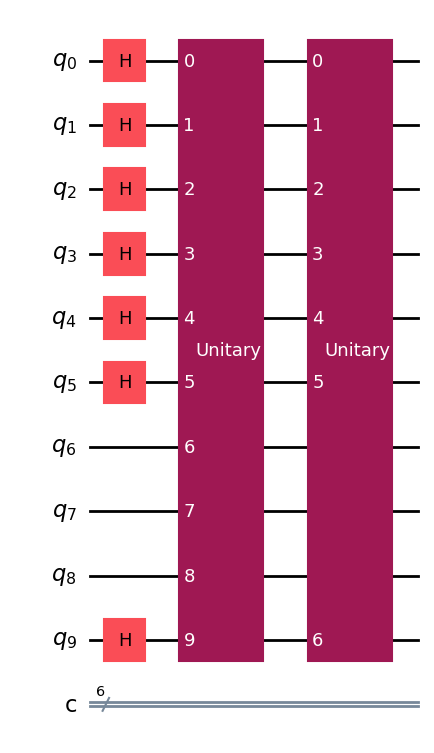

In [25]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Configuration
num_qubits = problem.num_qubits
vertex_qubit_count = problem.num_vertices * 2
output_qubit_index = num_qubits - 1
vertex_qubit_indices = list(range(vertex_qubit_count))

# Quantum and Classical Registers
q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(vertex_qubit_count, name='c')

# Oracle and Diffusion Operators
oracle_operator = GroversSearch.grover_oracle(
    num_qubits=num_qubits,
    num_vertices=problem.num_vertices,
    edges_list=problem.edges_list
)

diffusion_op = GroversSearch.diffusion_operator(num_vertices=problem.num_vertices)

# Circuit Construction
circuit = QuantumCircuit(q_regs, c_regs)

# Initialize superposition
circuit.h([q_regs[i] for i in vertex_qubit_indices])  # Color qubits
circuit.h(q_regs[output_qubit_index])                 # Output qubit

# Apply Grover's Oracle and Diffusion Operator
circuit.append(oracle_operator, q_regs)
circuit.append(diffusion_op, vertex_qubit_indices + [output_qubit_index])

# Visualize Circuit
circuit.draw("mpl")

Finally, the circuit is simulated, and the results are displayed as a measurement histogram, providing insight into how Grover’s search amplifies the correct solutions within the state space. This approach leverages quantum parallelism, efficiently evaluating all possible colorings in a single iteration.

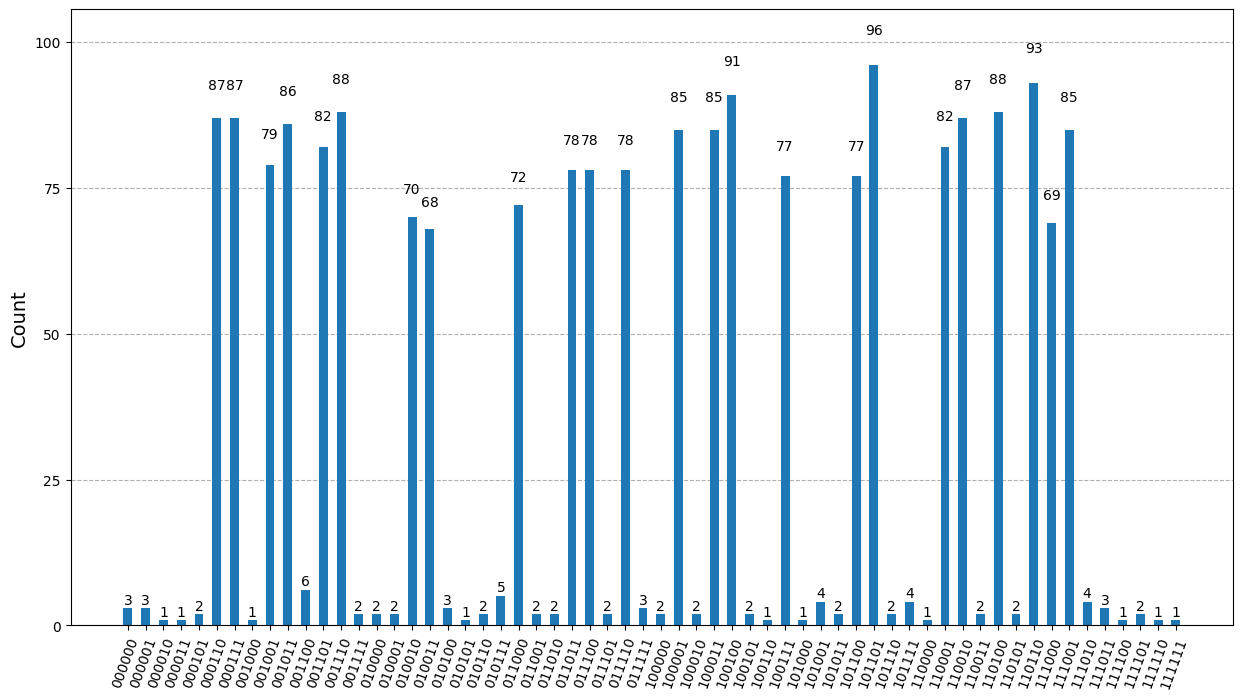

In [26]:
# Simulate and Plot Results
Utils.simulate(circuit=circuit, qubit_count=vertex_qubit_count, num_shots=2048)

This section demonstrates the use of Grover’s algorithm with the optimal number of iterations calculated based on the total state space and number of expected solutions. The circuit is initialized in superposition, and the oracle and diffusion operators are applied repeatedly to amplify the probability of measuring valid colorings. This iterative approach increases the likelihood of observing correct solutions upon measurement, enhancing the effectiveness of the search.

Number of Iterations: 1


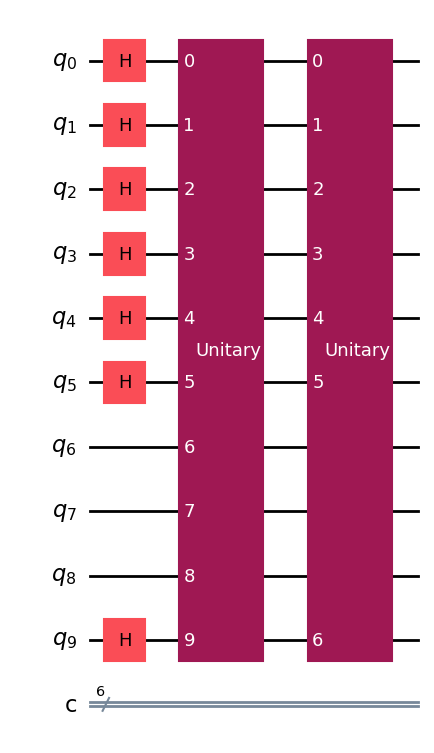

In [27]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Define constants for qubit layout
num_qubits = problem.num_qubits
num_vertex_qubits = problem.num_vertices * 2
output_qubit_index = num_qubits - 1
vertex_qubit_indices = list(range(num_vertex_qubits))

# Calculate optimal number of Grover iterations
num_iter = Utils.get_num_iter(
    num_qubits=(num_qubits - problem.num_edges),  # Exclude ancilla qubits
    num_solutions=24
)
print(f"Number of Iterations: {num_iter}")

# Create quantum and classical registers
q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_vertex_qubits, name='c')
circuit = QuantumCircuit(q_regs, c_regs)

# Prepare initial superposition
circuit.h([q_regs[i] for i in vertex_qubit_indices])  # Vertex color qubits
circuit.h(q_regs[output_qubit_index])                 # Output qubit

# Generate oracle and diffusion operators
oracle_operator = GroversSearch.grover_oracle(
    num_qubits=num_qubits,
    num_vertices=problem.num_vertices,
    edges_list=problem.edges_list
)

diffusion_operator = GroversSearch.diffusion_operator(num_vertices=problem.num_vertices)

# Apply Grover iterations
for _ in range(num_iter):
    circuit.append(oracle_operator, q_regs)
    circuit.append(diffusion_operator, vertex_qubit_indices + [output_qubit_index])

# Visualize the circuit
circuit.draw("mpl")

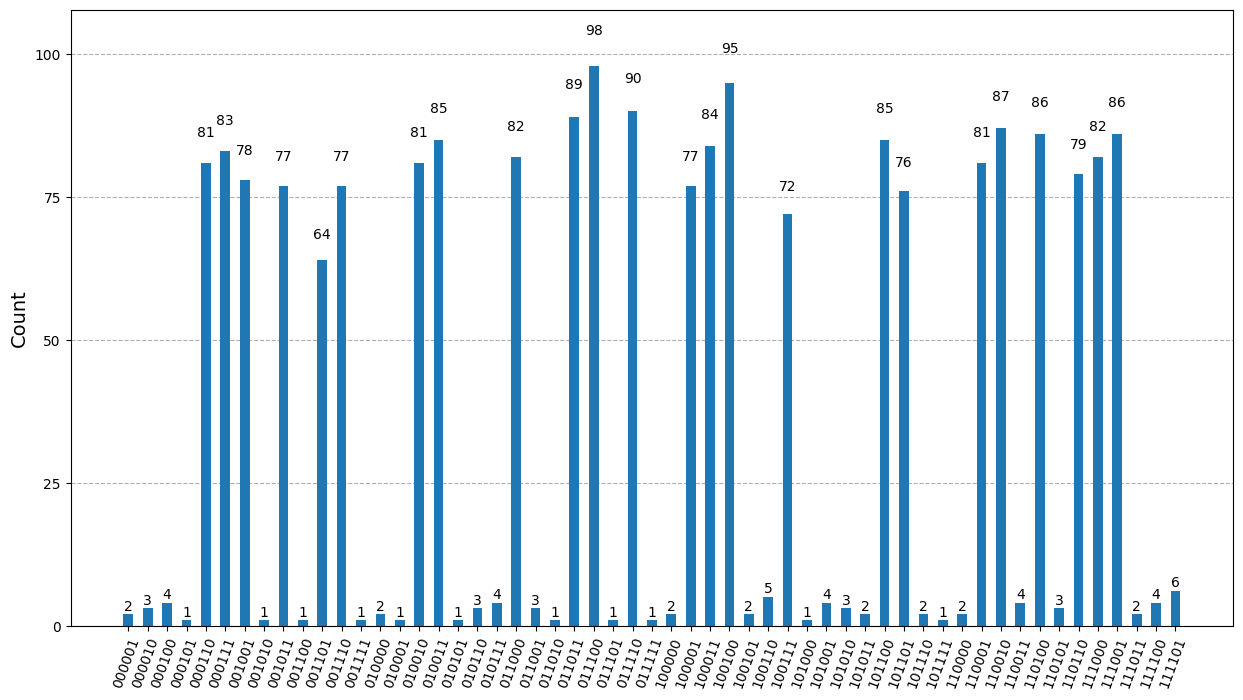

In [28]:
# Simulate and Plot Results
Utils.simulate(circuit=circuit, qubit_count=vertex_qubit_count, num_shots=2048)

## Apply Grover's Search on the Problem (with Ristricted State Space, i.e., Only Valid Colors)

This section applies Grover’s search algorithm to the graph coloring problem using a restricted state space, where the initial superposition includes only valid color combinations. Specifically, states containing the disallowed color encoding "11" are excluded during initialization, significantly reducing the search space and improving the efficiency of the algorithm. The circuit begins by initializing the valid color states using a custom state preparation operator, followed by a Hadamard gate on the output qubit to prepare it for phase marking. A single iteration of Grover’s algorithm is then applied, consisting of a custom oracle to mark color conflicts and a diffusion operator tailored to reflect around the restricted initialization. This focused search approach is more efficient than searching over all possible combinations, especially when prior knowledge allows certain states to be pruned. The final circuit is visualized, and the simulation results reveal how the quantum algorithm amplifies valid colorings. This method demonstrates the benefit of combining domain-specific constraints with quantum amplitude amplification.

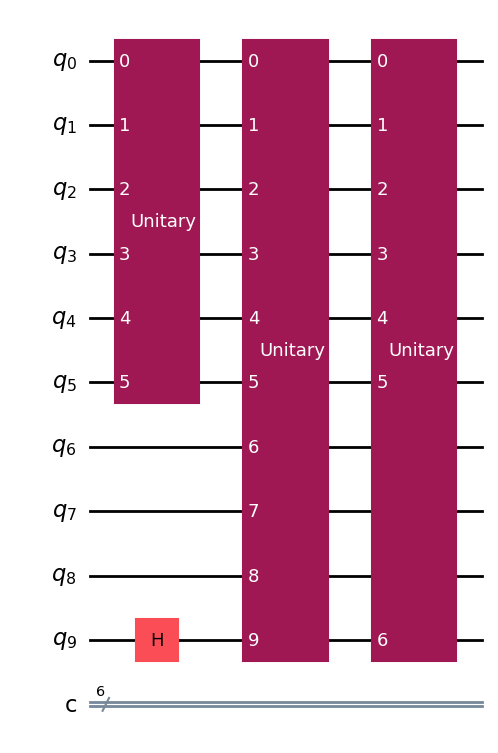

In [29]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Define constants
num_qubits = problem.num_qubits
num_vertex_qubits = problem.num_vertices * 2
output_qubit_index = num_qubits - 1
vertex_qubit_indices = list(range(num_vertex_qubits))

# Quantum and Classical Registers
q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_vertex_qubits, name='c')
circuit = QuantumCircuit(q_regs, c_regs)

# Build components
restrict_operator = GroversSearch.circuit_initializer(
    num_qubits=num_vertex_qubits,
    restrict_states=["11"]
)
oracle_operator = GroversSearch.grover_oracle(
    num_qubits=num_qubits,
    num_vertices=problem.num_vertices,
    edges_list=problem.edges_list
)
diffusion_operator = GroversSearch.diffusion_operator(
    num_vertices=problem.num_vertices,
    custom_initializer=restrict_operator
)

# Initialize only allowed color states
circuit.append(restrict_operator, vertex_qubit_indices)

# Prepare output qubit
circuit.h(q_regs[output_qubit_index])

# Apply one Grover iteration
circuit.append(oracle_operator, q_regs)
circuit.append(diffusion_operator, vertex_qubit_indices + [output_qubit_index])

# Visualize Circuit
circuit.draw("mpl")

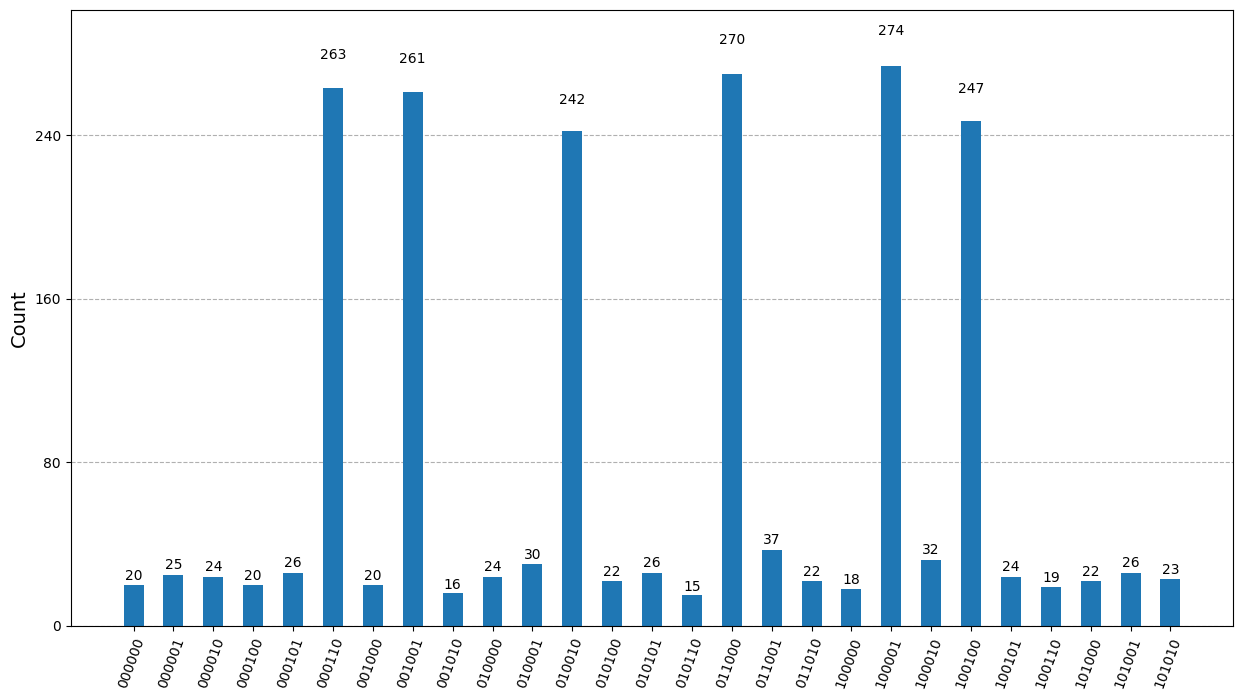

In [30]:
# Simulate and Plot Results
Utils.simulate(circuit=circuit, qubit_count=num_vertex_qubits, num_shots=2048)

This section applies Grover’s algorithm with multiple iterations to amplify the probability of measuring valid graph colorings from a restricted superposition of states. The circuit is initialized using a custom operator that excludes disallowed color encodings (e.g., "11"), followed by repeated applications of the Grover oracle and diffusion operator. By executing three iterations, the amplitude of correct solutions is progressively enhanced, increasing the likelihood of observing valid outputs upon measurement.

Number of Iterations: 2


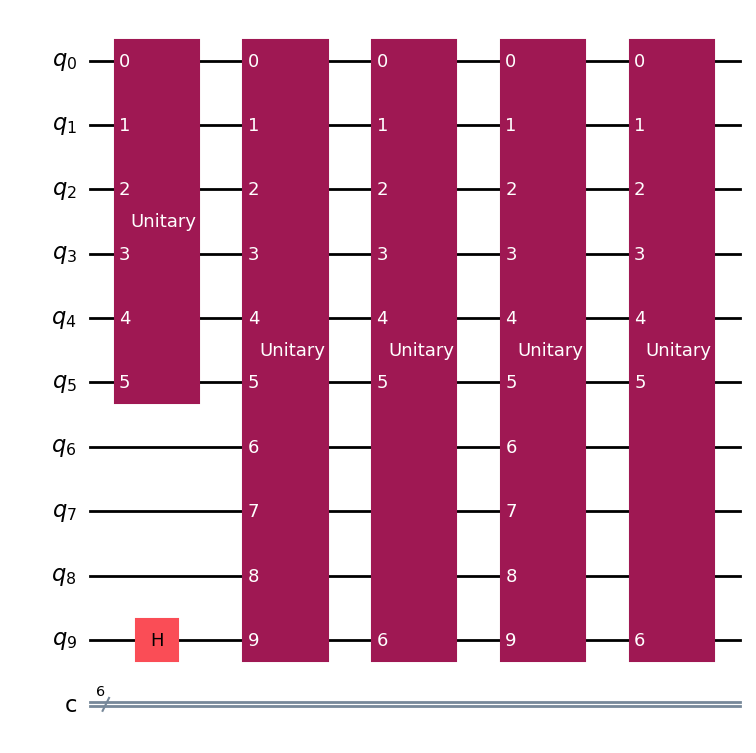

In [31]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Configuration
num_qubits = problem.num_qubits
num_vertex_qubits = problem.num_vertices * 2
output_qubit_index = num_qubits - 1
vertex_qubit_indices = list(range(num_vertex_qubits))

# Calculate Grover iterations based on reduced state space
num_iter = Utils.get_num_iter(
    num_qubits=(num_qubits - problem.num_edges),  # Exclude ancilla qubits
    num_solutions=12
)
print(f"Number of Iterations: {num_iter}")

# Quantum and Classical Registers
q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_vertex_qubits, name='c')
circuit = QuantumCircuit(q_regs, c_regs)

# Initialize only valid color states (excluding "11")
restrict_operator = GroversSearch.circuit_initializer(
    num_qubits=num_vertex_qubits,
    restrict_states=["11"]
)
circuit.append(restrict_operator, vertex_qubit_indices)

# Prepare output qubit for oracle marking
circuit.h(q_regs[output_qubit_index])

# Create oracle and diffusion operators
oracle_operator = GroversSearch.grover_oracle(
    num_qubits=num_qubits,
    num_vertices=problem.num_vertices,
    edges_list=problem.edges_list
)
diffusion_operator = GroversSearch.diffusion_operator(
    num_vertices=problem.num_vertices,
    custom_initializer=restrict_operator
)

# Apply Grover iterations
for _ in range(num_iter):
    circuit.append(oracle_operator, q_regs)
    circuit.append(diffusion_operator, vertex_qubit_indices + [output_qubit_index])

# Visualize the circuit
circuit.draw("mpl")

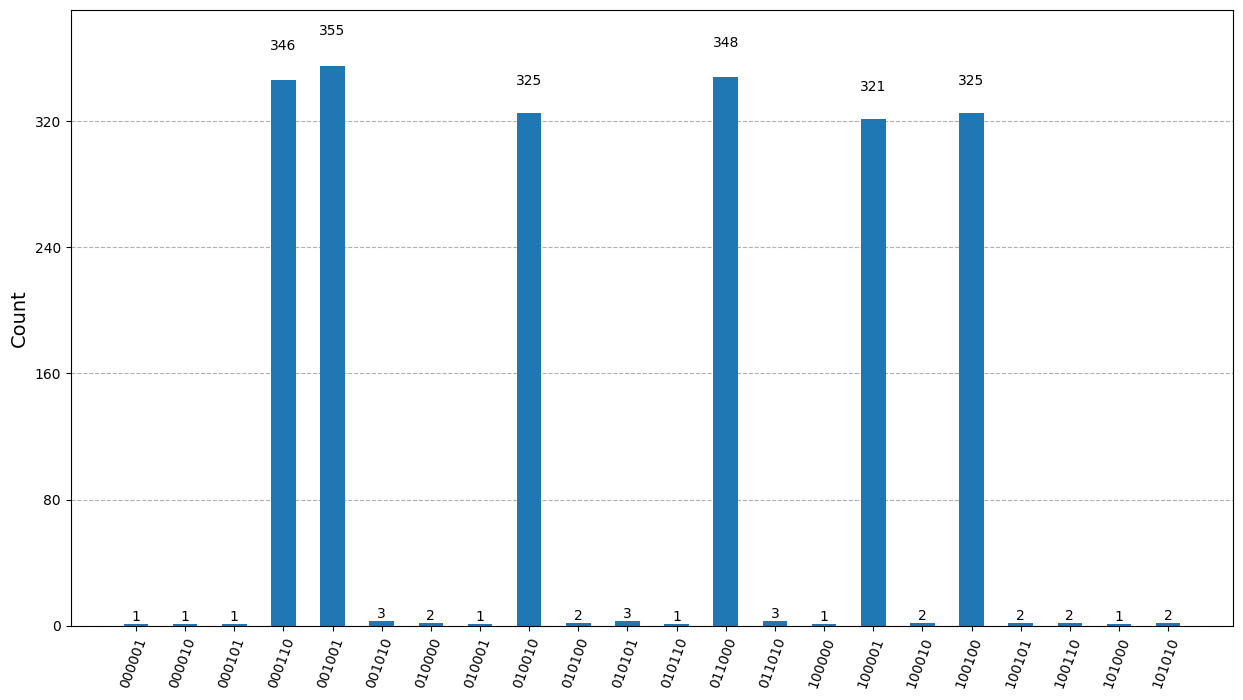

In [32]:
# Simulate and Plot Results
Utils.simulate(circuit=circuit, qubit_count=num_vertex_qubits, num_shots=2048)

## Conclusion

This project demonstrates a quantum approach to solving the graph coloring problem using Grover’s search algorithm implemented in Qiskit. By encoding valid color assignments into quantum states and constructing a custom oracle that flags color conflicts between adjacent vertices, the algorithm leverages quantum amplitude amplification to efficiently search for valid solutions. The design supports both full state-space superposition and restricted initialization, allowing for targeted exploration of only valid colorings—such as by excluding the "11" color encoding. Through iterative applications of the oracle and diffusion operators, the probability of measuring correct colorings is significantly amplified, as shown in simulations for different graph instances and iteration counts. Additionally, dynamic control over the number of Grover iterations based on the number of expected solutions enhances the scalability and effectiveness of the algorithm. The use of modular utilities for state initialization, entanglement checking, and circuit simulation further streamlines experimentation and visualization. Overall, the project showcases how combining quantum parallelism with problem-specific constraints can improve the efficiency of combinatorial optimization on near-term quantum hardware.